In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import sklearn
import glob

In [2]:
AkshayKumarfilepaths = glob.glob('dataset\Faces\Original Images\Original Images\Akshay Kumar\*.jpg') +glob.glob('dataset\Faces\Faces\Faces\Akshay Kumar_*.jpg')
Alexandrafilepaths = glob.glob('dataset\Faces\Original Images\Original Images\Alexandra Daddario\*.jpg') + glob.glob('dataset\Faces\Faces\Faces\Alexandra Daddario_*.jpg')
AliaBhattfilepaths = glob.glob('dataset\Faces\Original Images\Original Images\Alia Bhatt\*.jpg') + glob.glob('dataset\Faces\Faces\Faces\Alia Bhatt_*.jpg')
Courtneyfilepaths = glob.glob('dataset\Faces\Original Images\Original Images\Courtney Cox\*.jpg') + glob.glob('dataset\Faces\Faces\Faces\Courtney Cox_*.jpg')

In [3]:
AkshayKumarFDataset = tf.data.Dataset.from_tensor_slices(AkshayKumarfilepaths)
AlexandraFDataset = tf.data.Dataset.from_tensor_slices(Alexandrafilepaths)
AliaDataset = tf.data.Dataset.from_tensor_slices(AliaBhattfilepaths)
CourtneyDataset = tf.data.Dataset.from_tensor_slices(Courtneyfilepaths)

In [4]:
def preprocess_images(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.cast(img , tf.float32) / 255.0
    img = tf.image.resize_with_pad(img , 250 ,250 )
    return img

data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(mode = 'horizontal' , seed = 42),
                                         tf.keras.layers.RandomRotation(factor = 0.05, seed = 42),
                                         tf.keras.layers.RandomContrast(factor = 0.2, seed = 42)])

In [5]:
AkhshayTensor = tf.TensorArray(tf.float32, size = 0, dynamic_size = True )
AlexandraTensor = tf.TensorArray(tf.float32, size = 0 , dynamic_size = True)
AliaTensor = tf.TensorArray(tf.float32, size = 0, dynamic_size= True)
CourtneyTensor = tf.TensorArray(tf.float32, size = 0, dynamic_size = True)

In [6]:
AkshayKumarFDataset = AkshayKumarFDataset.map(preprocess_images)
AlexandraFDataset = AlexandraFDataset.map(preprocess_images)
AliaDataset = AliaDataset.map(preprocess_images)
CourtneyDataset = CourtneyDataset.map(preprocess_images)

In [7]:
for img in AkshayKumarFDataset:
    AkhshayTensor = AkhshayTensor.write(AkhshayTensor.size(), img)
for img in AlexandraFDataset:
    AlexandraTensor = AlexandraTensor.write(AlexandraTensor.size(), img)
for img in AliaDataset:
    AliaTensor = AliaTensor.write(AliaTensor.size(), img)
for img in CourtneyDataset:
    CourtneyTensor = CourtneyTensor.write(CourtneyTensor.size(), img)           

In [8]:
AkhshayTensor = AkhshayTensor.stack()
AlexandraTensor = AlexandraTensor.stack()
AliaTensor = AliaTensor.stack()
CourtneyTensor = CourtneyTensor.stack()

In [9]:
AkshayLabels = tf.ones(AkhshayTensor.shape[0]*2, 1) - 1
AlexandraLabels = tf.ones(AlexandraTensor.shape[0]*2, 1) * 2 - 1
AliaLabels = tf.ones(AliaTensor.shape[0]*2, 1)*3 - 1
CourtneyLabels = tf.ones(CourtneyTensor.shape[0]*2, 1)*4 - 1

In [10]:
AugAk = data_augmentation(AkhshayTensor)
AugAlex = data_augmentation(AlexandraTensor)
AugAlia = data_augmentation(AliaTensor)
AugCourtney = data_augmentation(CourtneyTensor)

In [11]:
AkFinal = tf.concat([AkhshayTensor, AugAk], axis = 0)
AlexFinal = tf.concat([AlexandraTensor, AugAlex], axis = 0)
AliaFinal = tf.concat([AliaTensor, AugAlia], axis = 0)
CourtneyFinal = tf.concat([CourtneyTensor, AugCourtney], axis = 0)

In [12]:
AkImgDataset = tf.data.Dataset.from_tensor_slices((AkFinal, AkshayLabels))
AlexImgDataset = tf.data.Dataset.from_tensor_slices((AlexFinal, AlexandraLabels))
AliaImgDataset = tf.data.Dataset.from_tensor_slices((AliaFinal, AliaLabels))
CourtneyImgDataset = tf.data.Dataset.from_tensor_slices((CourtneyFinal, CourtneyLabels))

In [13]:
Aksplitindex  = int(0.8*(len(AkFinal)))
Alexsplitindex = int(0.8*(len(AlexFinal)))
Aliasplitindex = int(0.8*(len(AliaFinal)))
Courtneysplitindex = int(0.8*(len(CourtneyFinal)))

AkImgDataset = AkImgDataset.shuffle(buffer_size=len(AkFinal), seed=1)
Aktrain_dataset = AkImgDataset.take(Aksplitindex)
Akval_dataset = AkImgDataset.skip(Aksplitindex)

AlexImgDataset = AlexImgDataset.shuffle(buffer_size= len(AlexFinal), seed = 1)
Alextrain_dataset = AlexImgDataset.take(Alexsplitindex)
Alexval_dataset = AlexImgDataset.skip(Alexsplitindex)

AliaImgDataset = AliaImgDataset.shuffle(buffer_size= len(AliaFinal), seed = 1)
Aliatrain_dataset = AliaImgDataset.take(Aliasplitindex)
Aliaval_dataset = AliaImgDataset.skip(Aliasplitindex)

CourtneyImgDataset = CourtneyImgDataset.shuffle(buffer_size= len(CourtneyFinal), seed = 1)
Courtneytrain_dataset = CourtneyImgDataset.take(Courtneysplitindex)
Courtneyval_dataset = CourtneyImgDataset.skip(Courtneysplitindex)

train_dataset = Aktrain_dataset.concatenate(Alextrain_dataset).concatenate(Aliatrain_dataset).concatenate(Courtneytrain_dataset)
val_dataset = Akval_dataset.concatenate(Alexval_dataset).concatenate(Aliaval_dataset).concatenate(Courtneyval_dataset)

In [14]:
train_dataset = train_dataset.batch(32)
val_dataset = val_dataset.batch(32)

## Utility Functions

In [15]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir='FaceRecogLogs'):
  return Path(root_logdir)/strftime('rin_%Y_%m_%d_%H_%M_%S')

logdir = get_run_logdir()

In [16]:
import os


model_dir = 'model'
os.makedirs(model_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'FaceRecognition_best.keras')

## Model

In [17]:
class FaceDetectionCNN(tf.keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.preprocess_inputs_ = tf.keras.applications.inception_v3.preprocess_input
    self.base_model = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top=False)
    self.EmbeddingNet_ = tf.keras.Sequential([
                                             tf.keras.layers.Dense(256, activation = tf.keras.activations.relu,
                                                                   kernel_regularizer = tf.keras.regularizers.l2(0.1),
                                                                   kernel_initializer = tf.keras.initializers.he_normal()),
                                             tf.keras.layers.BatchNormalization(),                      
                                             tf.keras.layers.Dense(256, activation = tf.keras.activations.relu,
                                                                   kernel_regularizer = tf.keras.regularizers.l2(0.1)),
                                             tf.keras.layers.Dropout(0.2),
                                             tf.keras.layers.Dense(128, activation = tf.keras.activations.relu,
                                                                   kernel_initializer = tf.keras.initializers.glorot_normal()),
                                             tf.keras.layers.BatchNormalization(),                      
                                             tf.keras.layers.Dropout(0.2),                      
                                             tf.keras.layers.Dense(64, activation = tf.keras.activations.relu,
                                                                   kernel_regularizer = tf.keras.regularizers.l2(0.1)),
                                             tf.keras.layers.Dropout(0.2),
                                             tf.keras.layers.Dense(32, activation = tf.keras.activations.relu)
                                             ])
    self.GlobAvg_ = tf.keras.layers.GlobalAveragePooling2D()
    self.classifier = tf.keras.layers.Dense(4, activation = 'softmax')

  def call(self, inputs, training = False):
    x = inputs
    processed_inputs = self.preprocess_inputs_(x)
    x = self.base_model(processed_inputs, training = training)
    x = self.GlobAvg_(x)
    embeddings = self.EmbeddingNet_(x, training = training)
    return self.classifier(embeddings)
  
  def get_config(self):
    base_config = super().get_config()
    base_config.update({'preprocess_inputs_': self.preprocess_inputs_ ,
                        'base_model' : self.base_model})
    return base_config

In [18]:
class DelayModelGraphs(tf.keras.callbacks.Callback):
    def __init__(self, unfreeze_epoch,new_lr = None, **kwargs):
        super().__init__(**kwargs)
        self.unfreeze_epoch = unfreeze_epoch
        self.DelayedLr_ = new_lr

    def on_epoch_begin(self, epoch , logs = None):
        if epoch == self.unfreeze_epoch:
            self.model.base_model.trainable = True
            if self.DelayedLr_ is not(None):
              self.model.base_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = self.DelayedLr_))
            print('Unfreezing base model')

class UpdateCurrentEpoch(tf.keras.callbacks.Callback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.current_epoch = 0

    def on_epoch_begin(self, epoch, logs = None):
        self.current_epoch = epoch


class TensorBoardFeatureMapVisualizer(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, frequency=1, **kwargs):
        super().__init__(**kwargs)
        self.freq = frequency
        self.writer = tf.summary.create_file_writer(log_dir)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.freq == 0:
            base_model = self.model.base_model
            self.intermediate_model = tf.keras.Model(inputs=base_model.inputs,
                                                     outputs=[layer.output for layer in base_model.layers if isinstance(layer, tf.keras.layers.Conv2D)])
            self.subject_image = next(iter(train_dataset.take(1)))[0][0:1]

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.freq == 0:
            feature_maps = self.intermediate_model.predict(self.subject_image)
            with self.writer.as_default():
                for i, feature_map in enumerate(feature_maps):
                    feature_map = tf.reduce_mean(feature_map, axis=-1, keepdims=True)
                    tf.summary.image('FeatureMap_{}'.format(i), feature_map, step=epoch)

## HyperModel Tuner

In [19]:
import keras_tuner as kt

class HyperModel(kt.HyperModel):
    def build(self, hp):
        learning_rate = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling= 'log')
        optimizer = hp.Choice('optimizer', values = ['adam', 'sgd'])
        if optimizer=='adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        else :
            optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate , momentum = 0.9)    
        model = FaceDetectionCNN()
        model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                      optimizer = optimizer,
                      metrics = ['accuracy'])
        return model

In [20]:
HyperModelTuner = kt.BayesianOptimization(hypermodel = HyperModel(),
                                          objective= 'accuracy',
                                          max_trials= 5,
                                          directory = 'FaceDetetcion Hypermodel',
                                          project_name = 'FaceRecogTunerTrials',
                                          seed = 42)

Reloading Tuner from FaceDetetcion Hypermodel\FaceRecogTunerTrials\tuner0.json


In [21]:
HyperModelTuner.search(train_dataset ,
                        epochs = 8,
                        validation_data = val_dataset,
                        callbacks = [DelayModelGraphs(unfreeze_epoch=4)] )

In [22]:
HyperModelTuner.get_best_hyperparameters()[0].values

{'learning_rate': 0.0019004375238737127, 'optimizer': 'adam'}

In [23]:
lr = HyperModelTuner.get_best_hyperparameters()[0].values['learning_rate']
optm = HyperModelTuner.get_best_hyperparameters()[0].values['optimizer']

In [24]:
model = FaceDetectionCNN()
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
              metrics =['accuracy'])

In [25]:
history = model.fit(train_dataset , epochs = 50 , callbacks = [TensorBoardFeatureMapVisualizer(str(logdir)),
                                                               DelayModelGraphs(15),
                                                               tf.keras.callbacks.ModelCheckpoint(filepath = model_path,
                                                                                                  monitor = 'accuracy',
                                                                                                  save_weights_only = False,
                                                                                                  save_best_only = True,
                                                                                                  verbose = 1),
                                                               tf.keras.callbacks.TensorBoard(str(logdir),
                                                                                              histogram_freq = 1,
                                                                                              write_graph = True,
                                                                                              write_images = True)],
                    validation_data = val_dataset)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepep - accuracy: 0.1989 - loss: 66.439

Epoch 1: accuracy improved from -inf to 0.17770, saving model to model\FaceRecognition_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 209s 6s/step - accuracy: 0.1982 - loss: 65.8498 - val_accuracy: 0.2807 - val_loss: 6077.9780
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.3240 - loss: 12.997

Epoch 2: accuracy improved from 0.17770 to 0.29029, saving model to model\FaceRecognition_best.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.3229 - loss: 12.8861 - val_accuracy: 0.3246 - val_loss: 12.0329
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepep - accuracy: 0.1614 - loss: 4.029

Epoch 3: accuracy did not improve from 0.29029
29/29 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.1628 - loss: 4.0069 - val_accuracy: 0.2807 - val_loss: 29975.5234
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepep - accuracy: 0.2751 - loss: 2.235

Epoch 4: accuracy did not improve from 0.29029
29/29 ━━━━━━━━━

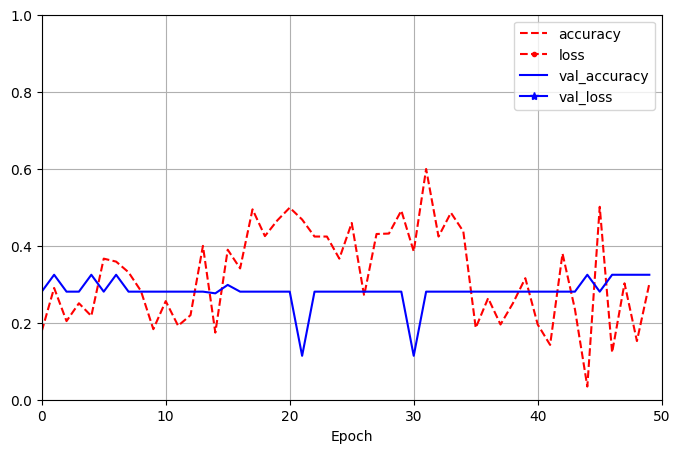

In [26]:
pd.DataFrame(history.history).plot(figsize = (8,5), xlim = [0,50] , ylim = [0,1], grid = True , xlabel = 'Epoch', 
                                   style = ['r--', 'r--.', 'b-', 'b-*'])
plt.show()

## Model Analysis and Scope
As we can see my model seems to have not performed well , but thats because I chose a learning rate thats quite low . and my PC isnt powerful enough to process these images as fast as I would typically want it to. However I did extract the best model weights by a checkpoint . I can use the best model to make predcitions.

## Convolutions

I implemented a callback that allows me to look at all the feature maps of an image and look at all the different changes that it goesthrough throughout different epochs.
>Observations:
The model is working perfectly fine but the lack of a well defined dataset makes it hard to actually learn from the features.
Here are the extracted feature maps during some of the epochs . I have used TensorBoard for visualisation here:


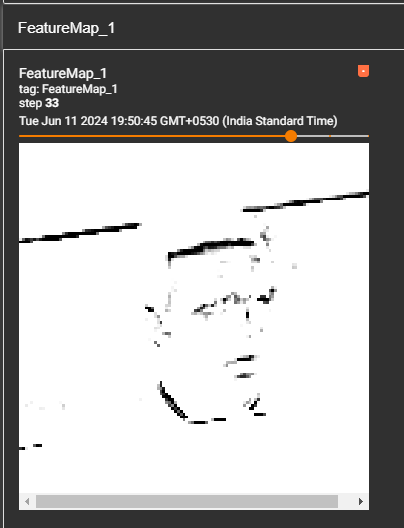   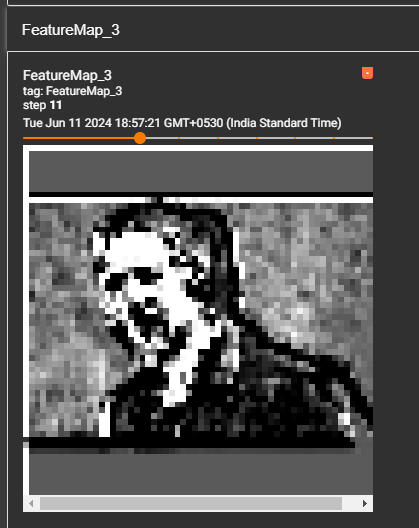  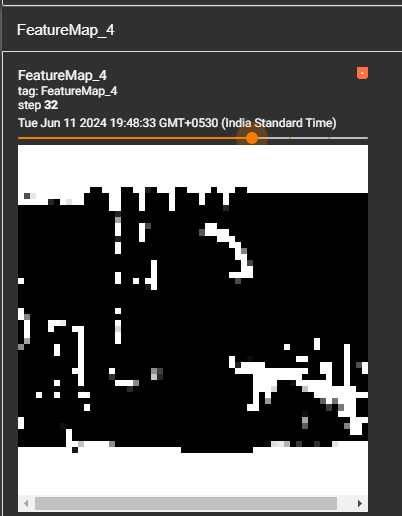

As you can see the features are being processed appropriately ,  but the lack of proper samples and correct distribution has resulted in bad performance

## Learning Evaluation

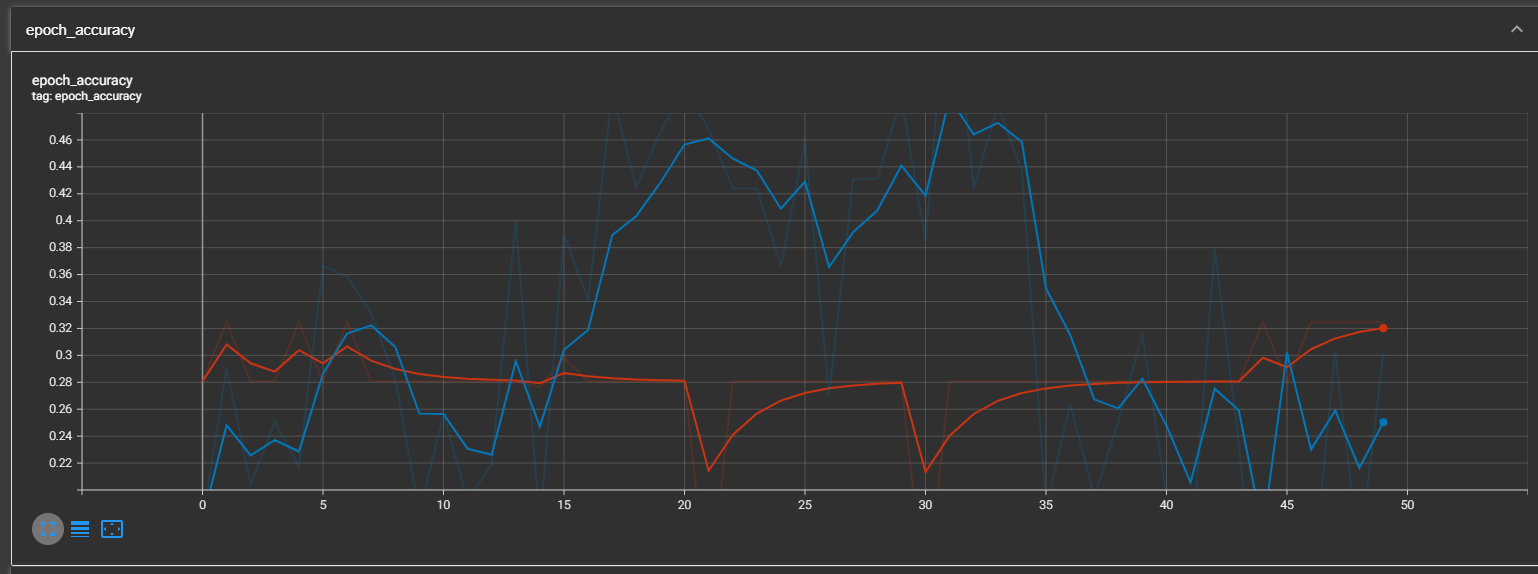

This is an interesting curve as we can see that the validation accuracy seems to have a relatively positive trend but unfortunately the train accuracy has taken a big dip after epoch no. 35 for some reason. This suggests that the model started to escape the minima and the kernels started to deviate a lot

## Learning Rate and Epoch vs Loss curves

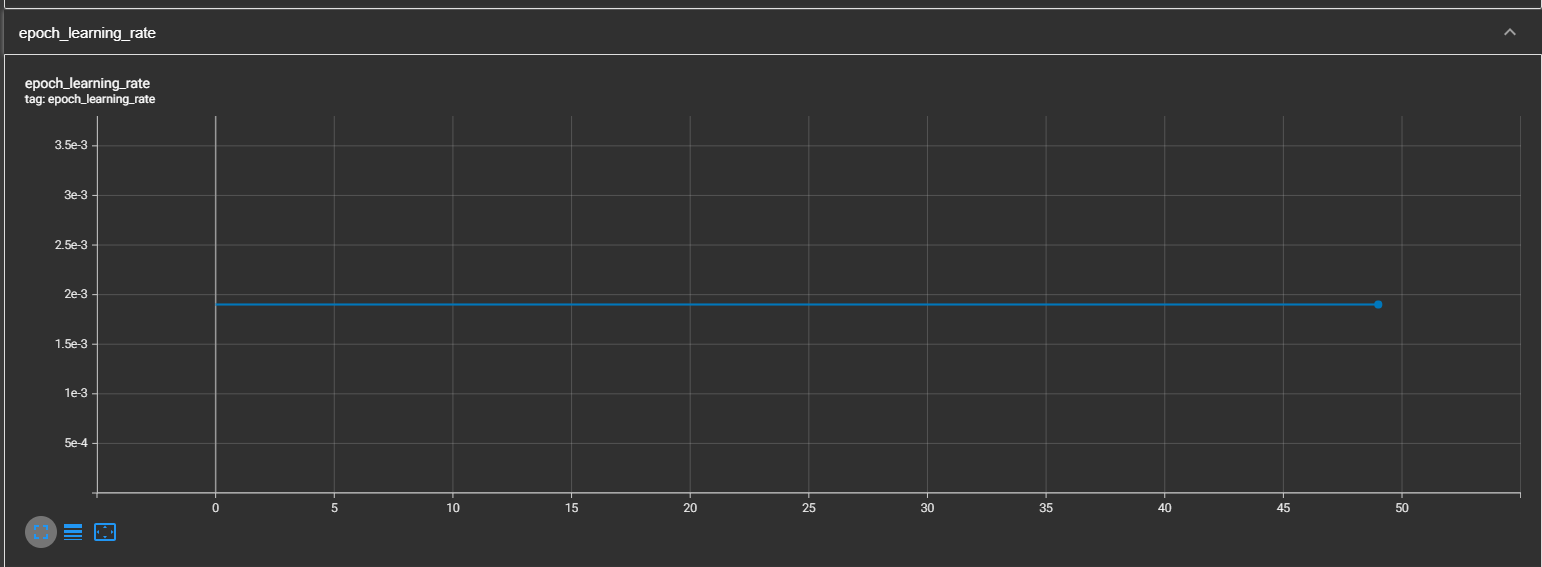

I decided not to change the learning rate after unfreezing the imported InceptionV3 model mostly because of the lack of computational power.

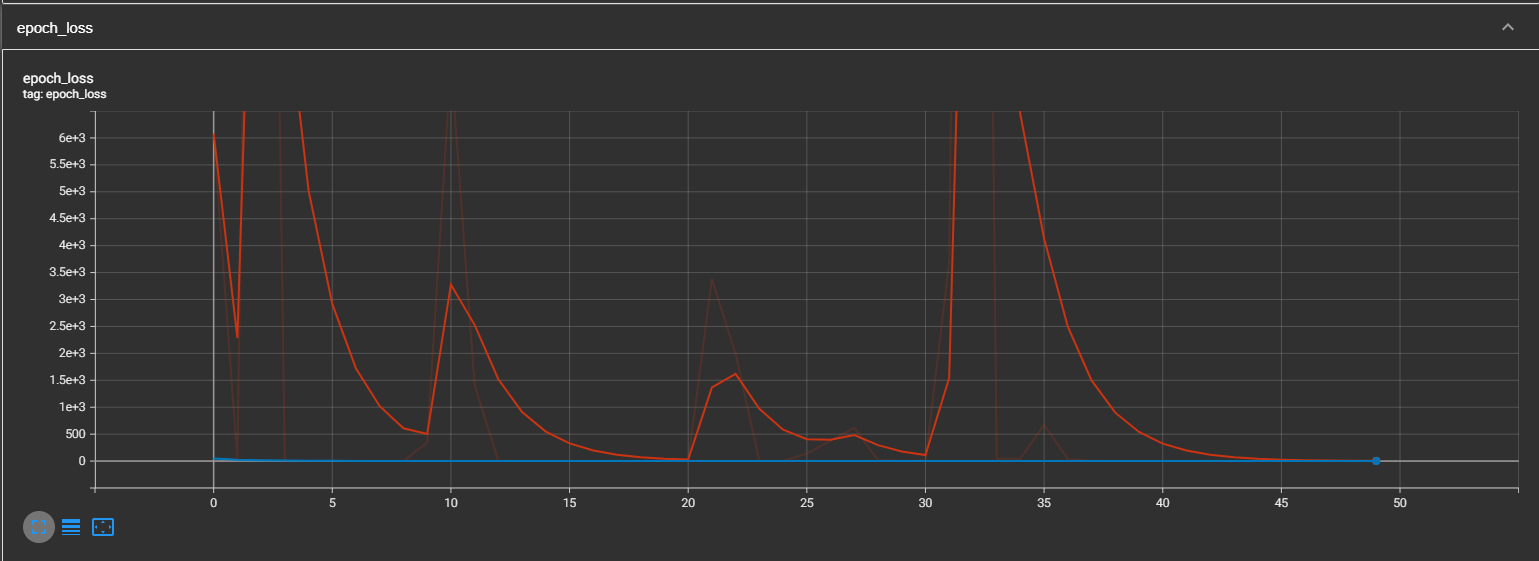

And as a result there are spikes in the loss curves mostly because the model is oscillating from the optimal weight kernels and producing results that deviate from the desired minima periodically.

## Analysis

I have successfully implemented a face recognition/detection model using transfer learning even though the results arent promising.

With a proper dataset the model would generalise well and would produce accuracy which is respectable for deployment.
The dataset consists of 4 people (faces) and I have augmented the data to increase the sample space.
I then added a Dense net to classify from the convolved data and make predictions.